### imports

In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras import metrics
from datasets import load_dataset, Dataset
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from tqdm import tqdm 
from collections import Counter
import random

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc,confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

import nltk
import pymorphy2
import re
from nltk.corpus import stopwords
from nltk import ngrams

import pickle

In [120]:
import warnings
warnings.simplefilter('ignore')

#### useful visualization functions

In [72]:
palette_sentiment = {
    'Negative': 'tab:red',
    'Neutral': 'tab:blue',
    'Positive': 'tab:green'
}

label_dict =  {'Negative':0, 'Neutral':1, 'Positive':2}
inversed_label_dict = {v: k for k, v in label_dict.items()}


def plot_distribution(df, columns):
    """
    Построение гистограмм для списка колонок датафрейма
    """
    for col in columns:
        if df[col].dtype == object:
            continue
        plt.figure(figsize=(9, 7))
        sns.distplot(df[col], bins=50)
        plt.axvline(np.median(df[col]), label='median', color='k', linestyle='--')
        plt.title(f'{col} distribution')
        plt.legend()
        plt.show()
        
def plot_count(df, columns):
    """
    Построение столбчатых диаграмм для списка колонок датафрейма
    """
    for col in columns:
        plt.figure(figsize=(9, 7))
        sns.countplot(x=df[col], data=df)
        if col == 'sentiment':
            sns.countplot(x=df[col], data=df, palette=palette_sentiment)
        else:
            sns.countplot(x=df[col], data=df)
        plt.title(f'{col} distribution')
        plt.show()
        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Визуализация матрицы ошибок
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_nn_metrics(history):  
    """
    Визуализация изменения значений функции потерь и метрики accuracy в процессе обучения нейросети 
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    plt.subplots_adjust(wspace=0.3, hspace=0.5) 

    ax[0].plot(history.history['accuracy'], 
             label='Доля верных ответов на train')
    ax[0].plot(history.history['val_accuracy'], 
             label='Доля верных ответов на val')
    ax[0].legend()
    ax[0].set_title('Метрика "accuracy"', fontsize=15)


    ax[1].plot(history.history['loss'], 
             label='Потери на train')
    ax[1].plot(history.history['val_loss'], 
             label='Потери на val')
    ax[1].legend()
    ax[1].set_title('Метрика "loss"', fontsize=15)
    
    
def plot_multiclass_roc(y_pred, y_test, n_classes, figsize=(10, 7)):
    
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], color=palette_sentiment[inversed_label_dict[i]],
                label=f'ROC curve (area = {round(roc_auc[i], 2)}) for label {inversed_label_dict[i]}' )
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

### Intro

Данные собраны с сайта музыкального магазина pop-music.ru. Скрипты по сбору данных содержатся в ноутбуках Collecting links.ipynb и Collecting data.ipynb

In [741]:
df = pd.read_csv('Data/reviews.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,author,date,product_id,product_name,rate,text
0,Егор Гумеров,15.10.2017,888880022374,АКУСТИЧЕСКАЯ ГИТАРА STAGG SA20D RED,4,Это моя первая гитара. Консультант ответил на ...
1,Гость,15.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,Пожалуйста скажите кто-нибудь у кого он есть т...
2,Гость,03.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,5,клевая вещь. ка будет в МСК?
3,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,Пришлось снизить оценку -1 т.к. выснилось что ...
4,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,4,"Под ХР сразу не заработал, дрова надо везти с ..."


In [742]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11214 entries, 0 to 11213
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   author        11209 non-null  object
 1   date          11214 non-null  object
 2   product_id    11214 non-null  int64 
 3   product_name  11214 non-null  object
 4   rate          11214 non-null  int64 
 5   text          11213 non-null  object
dtypes: int64(2), object(4)
memory usage: 525.8+ KB


#### Null values

In [743]:
df.isnull().sum()

author          5
date            0
product_id      0
product_name    0
rate            0
text            1
dtype: int64

Для построения классификации по тексту отзывов имя автора отзыва роли  не играет, эти пропуски можно заполнить. Строки с пропусками в поле текст для модели ничего не дадут, их можно удалить.

In [744]:
df['author'] = df['author'].fillna('Неизвестен')
df = df.dropna()
df.isnull().sum()

author          0
date            0
product_id      0
product_name    0
rate            0
text            0
dtype: int64

### Preprocessing

In [745]:
df.rate.unique()

array([4, 3, 5, 2, 1, 0], dtype=int64)

Есть оценки 0. Если посмотреть на текст отзывов с рейтингом 0, увидим, что большая часть не несет эмоциональной окраски, а представляет из себя вопросы к тому или иному товару. Для анализа настроений текстов эти отзывы не информативны, можно убрать их из датасета

In [747]:
df[df.rate==0].sample(15)

,author,date,product_id,product_name,rate,text
7309,Иван,02.05.2020,888880023176,Комплект для звукозаписи STEINBERG UR22 MKII R...,0,"Скажите, что лучше взять - этот комплект или s..."
10686,kirian,30.03.2021,888880026082,Электрогитара IBANEZ RGA42FM-BLF,0,"Подскажите, пожалуйста, а модель серого цвета,..."
3290,Иван,29.05.2020,888880025141,Настольная микрофонная стойка FZONE PC-2,0,Какая максимальная высота подъема
5776,Алексей,09.01.2021,888880017122,USB АУДИО ИНТЕРФЕЙС BEHRINGER U-PHORIA UM2,0,Здравствуйте! Имеется эта карта и хочу к ней п...
5250,Виталий,07.04.2019,888880025140,Микрофонный пантограф FZONE NB-35,0,"Здравствуйте, подойдёт микрофон dexp u400?"
4533,Клиент,29.10.2021,888880028847,Аудиоинтерфейс TASCAM MiNiSTUDIO Creator US-42B,0,"Мощности хватит, чтобы корректно работать с ми..."
5923,Владимир,31.05.2020,888880025072,Комплект AUDIENT ID14 + SE ELECTRONICS SE 2200,0,"Здравствуйте , когда будет в наличии ?"
4575,Nikita,09.05.2020,888880023083,Микрофон TASCAM TM-80,0,что лучше Микрофон TASCAM TM-80 или AKG P120
840,Nikita,11.05.2020,88880005974,ДЕРЖАТЕЛЬ МИКРОФОННЫЙ ПАУК FORCE MK-6B,0,этот паук подойдет для микрофона SE ELECTRONIC...
3105,Гость,16.12.2012,88880005111,ГИТАРНАЯ ПЕДАЛЬ VOX V847A WAH WAH,0,В чём принципиальная разница между 847-й и 845...


In [748]:
df = df[df.rate!=0]

Распределение целевой переменной rate по классам несбалансированно. Выделим более крупные группы настроенйи отзывов по их оценкам.

In [749]:
df.rate.value_counts()

5    9408
4     900
3     432
2     169
1      88
Name: rate, dtype: int64

In [750]:
def get_sentiment(row):
    if row == 3 or row == 4:
        val = 'Neutral'
    elif row == 1 or row == 2:
        val = 'Negative'
    elif row == 5:
        val = 'Positive'
    else:
        val = -1
    return val

In [751]:
df['sentiment'] = df['rate'].apply(get_sentiment)

In [752]:
df[df.sentiment==-1] #все значения заполнены

,author,date,product_id,product_name,rate,text,sentiment


In [753]:
df.sentiment.value_counts()

Positive    9408
Neutral     1332
Negative     257
Name: sentiment, dtype: int64

In [754]:
df['dt'] = pd.to_datetime(df.date)
df.head()

,author,date,product_id,product_name,rate,text,sentiment,dt
0,Егор Гумеров,15.10.2017,888880022374,АКУСТИЧЕСКАЯ ГИТАРА STAGG SA20D RED,4,Это моя первая гитара. Консультант ответил на ...,Neutral,2017-10-15
1,Гость,15.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,Пожалуйста скажите кто-нибудь у кого он есть т...,Neutral,2010-06-15
2,Гость,03.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,5,клевая вещь. ка будет в МСК?,Positive,2010-03-06
3,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,Пришлось снизить оценку -1 т.к. выснилось что ...,Neutral,2010-05-18
4,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,4,"Под ХР сразу не заработал, дрова надо везти с ...",Neutral,2010-05-18


In [755]:
df['year'] = df['dt'].dt.year
df.head()

,author,date,product_id,product_name,rate,text,sentiment,dt,year
0,Егор Гумеров,15.10.2017,888880022374,АКУСТИЧЕСКАЯ ГИТАРА STAGG SA20D RED,4,Это моя первая гитара. Консультант ответил на ...,Neutral,2017-10-15,2017
1,Гость,15.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,Пожалуйста скажите кто-нибудь у кого он есть т...,Neutral,2010-06-15,2010
2,Гость,03.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,5,клевая вещь. ка будет в МСК?,Positive,2010-03-06,2010
3,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,Пришлось снизить оценку -1 т.к. выснилось что ...,Neutral,2010-05-18,2010
4,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,4,"Под ХР сразу не заработал, дрова надо везти с ...",Neutral,2010-05-18,2010


### Cleaning text for EDA

Примечание: на этом этапе я применяю лемматизацию и удаление стоп-слов, в частности за тем, чтобы посмотреть наиболее часто встречающиеся n-граммы в текстах отзывов. 

In [129]:
stops = stopwords.words('russian')
stops.append('это')
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')
morph = pymorphy2.MorphAnalyzer()

def review_to_wordlist(review, remove_stopwords=False ):

    # оставляем только буквенные символы
    review_text = re.sub("[^А-Яа-я]"," ", review)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    words = review_text.lower().split()
    words_lemmatized = [morph.parse(w)[0].normal_form for w in words]
    if remove_stopwords: # убираем стоп-слова
        words_lemmatized = [w for w in words_lemmatized if not w in stops]
    return(' '.join(words_lemmatized))

def review_to_sentences(review, tokenizer, remove_stopwords=False):
    # разбиваем обзор на предложения
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # применяем предыдущую функцию к каждому предложению
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [143]:
# df['sentences'] = df['text'].apply(lambda x: review_to_sentences(x, tokenizer, True))

In [758]:
review_to_wordlist(df['text'].values[0], True)

'первый гитара консультант ответить всё вопрос быстро оформить покупка гитара дойти спб ухта рк весь день взять гитара рука обнаружить гриф прогнуться именно бояться комплект идти шестигранник подкрутить гриф особый проблема ещё струна значительно возвышаться весь остальной прийтись подпилить порожек гитара приятный звук удобно лежать рука небольшой шаманство петь плясать крайне рекомендовать покупка'

In [760]:
df['text_cleaned'] = df['text'].apply(lambda x: review_to_wordlist(x, True))

In [761]:
df['text_cleaned'].values[0]

'первый гитара консультант ответить всё вопрос быстро оформить покупка гитара дойти спб ухта рк весь день взять гитара рука обнаружить гриф прогнуться именно бояться комплект идти шестигранник подкрутить гриф особый проблема ещё струна значительно возвышаться весь остальной прийтись подпилить порожек гитара приятный звук удобно лежать рука небольшой шаманство петь плясать крайне рекомендовать покупка'

In [762]:
df.head()

,author,date,product_id,product_name,rate,text,sentiment,dt,year,text_cleaned
0,Егор Гумеров,15.10.2017,888880022374,АКУСТИЧЕСКАЯ ГИТАРА STAGG SA20D RED,4,Это моя первая гитара. Консультант ответил на ...,Neutral,2017-10-15,2017,первый гитара консультант ответить всё вопрос ...
1,Гость,15.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,Пожалуйста скажите кто-нибудь у кого он есть т...,Neutral,2010-06-15,2010,пожалуйста сказать нибыть должный еле слышный ...
2,Гость,03.06.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,5,клевая вещь. ка будет в МСК?,Positive,2010-03-06,2010,клёвый вещь ка мск
3,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,3,Пришлось снизить оценку -1 т.к. выснилось что ...,Neutral,2010-05-18,2010,прийтись снизить оценка высниться помимо еобхо...
4,Гость,18.05.2010,888880000341,ПРЕДУСИЛИТЕЛЬ ART USBDUALPRE,4,"Под ХР сразу не заработал, дрова надо везти с ...",Neutral,2010-05-18,2010,хр сразу заработать дрова везти сайт странно б...


In [763]:
df.to_csv('Data/reviews_preprocessed_1412.csv', index=False)

### Some visualisations

In [7]:
# df = pd.read_csv('Data/reviews_preprocessed_1412.csv')

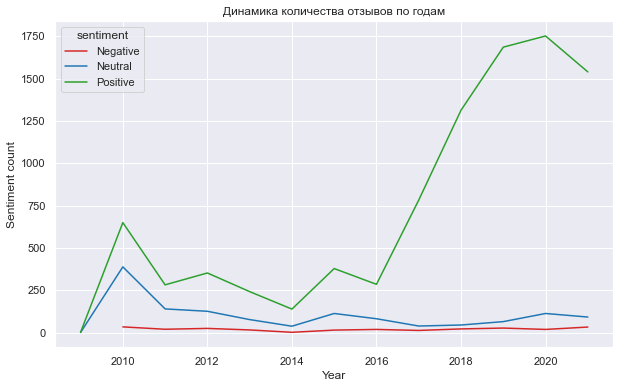

In [11]:
sns.set()
df.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True, style=palette_sentiment, figsize=(10, 6))
plt.title('Динамика количества отзывов по годам')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

Добавим столбцы, содержащие информацию о том, из скольки символов и из скольки слов состоит отзыв 

In [14]:
df['char_len'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

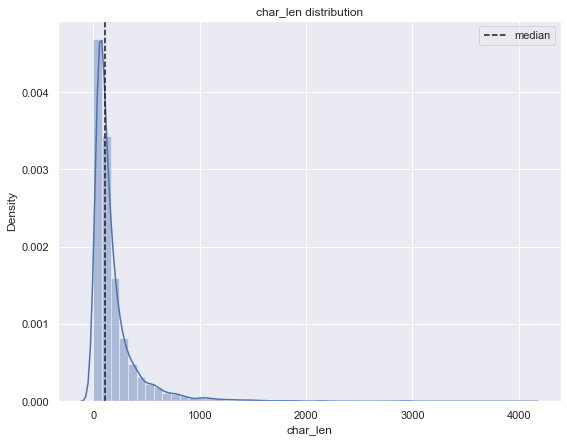

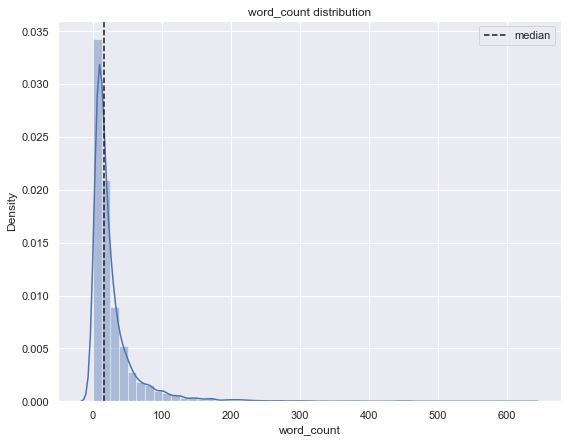

In [15]:
plot_distribution(df, ['char_len','word_count'])

Датасет содержит много коротких отзывов, однако есть отдельные тексты, состоящие из большого количества (сотни) слов

In [767]:
df.word_count.max()

627

In [27]:
print(f'Среднее количество слов в отзыве {round(np.mean(df.word_count))}')
print(f'Медианное количество {np.median(df.word_count).astype(int)}')

Среднее количество слов в отзыве 28
Медианное количество 16


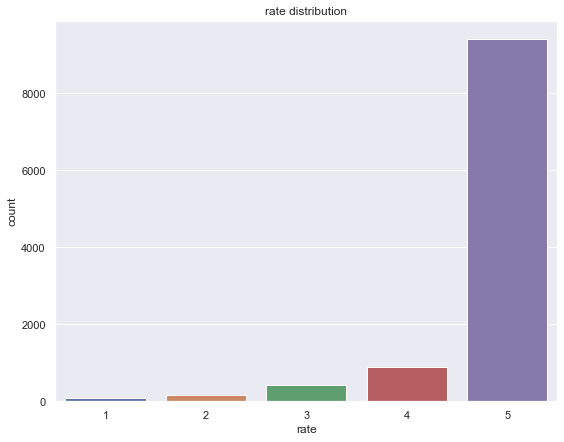

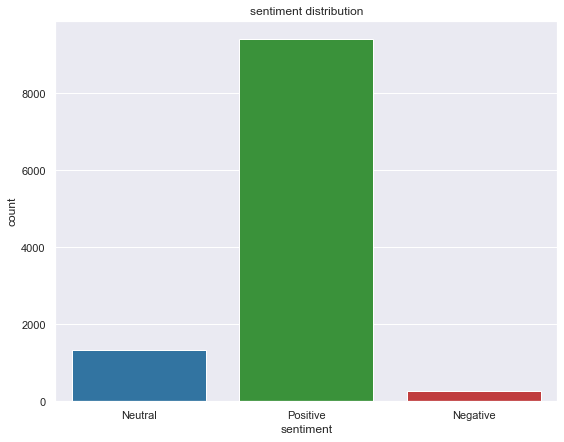

In [31]:
plot_count(df, ['rate', 'sentiment'])

Как уже было замечено ранее, наблюдаем сильный дисбаланс классов: положительных оценок много, остальные представлены в меньшем количестве

### Frequent n-grams

In [241]:
def most_frequent(words, sentiment):
    color='blue'
    if sentiment == 'Positive':
        color = 'green'
    elif sentiment == 'Neutral':
        color = 'grey'
    elif sentiment == 'Negative':
        color = 'red'

        
    freq_dict = Counter(words)
    freq_words = freq_dict.most_common(15)

    y = [x[0] for x in freq_words]
    x = [x[1] for x in freq_words]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=x, y=y, color=color).set_title(f'Most common {sentiment} words')

    plt.show()

In [194]:
def generate_ngrams(texts, n_range):
    result = []
    for t in texts:
        result += list(ngrams(t.split(), n_range))
        
    result = [' '.join(list(result[i])) for i in range(len(result))]
     
    return result

In [195]:
unigrams_pos = generate_ngrams(df[df.sentiment=='Positive'].text_cleaned.values, 1)
unigrams_neut = generate_ngrams(df[df.sentiment=='Neutral'].text_cleaned.values, 1)
unigrams_neg = generate_ngrams(df[df.sentiment=='Negative'].text_cleaned.values, 1)

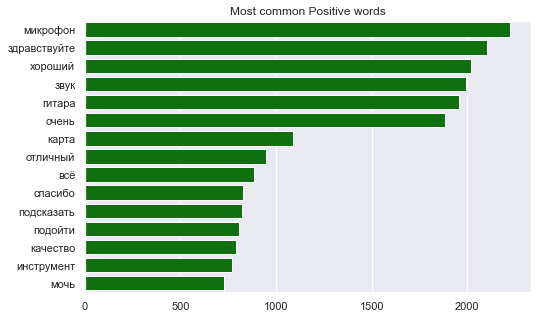

In [496]:
most_frequent(unigrams_pos, 'Positive')

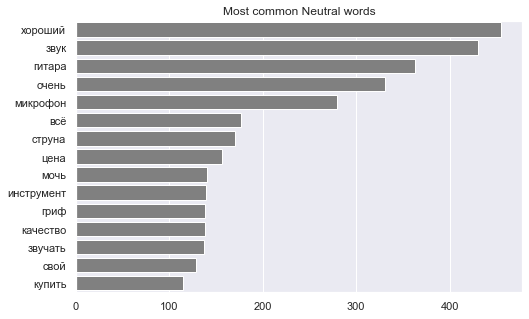

In [497]:
most_frequent(unigrams_neut, 'Neutral')

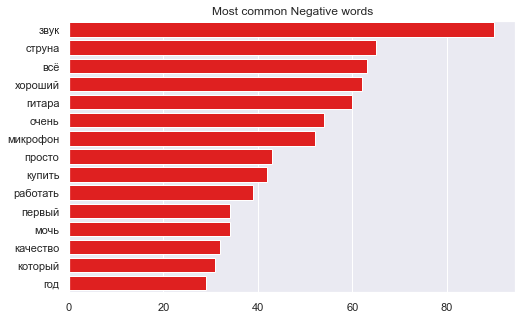

In [498]:
most_frequent(unigrams_neg, 'Negative')

In [245]:
bigrams_pos = generate_ngrams(df[df.sentiment=='Positive'].text_cleaned.values, 2)
bigrams_neut = generate_ngrams(df[df.sentiment=='Neutral'].text_cleaned.values, 2)
bigrams_neg = generate_ngrams(df[df.sentiment=='Negative'].text_cleaned.values, 2)

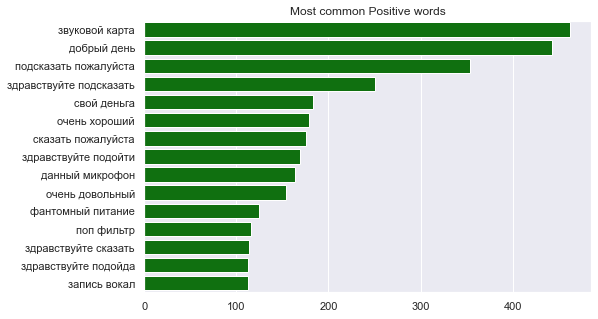

In [499]:
most_frequent(bigrams_pos, 'Positive')

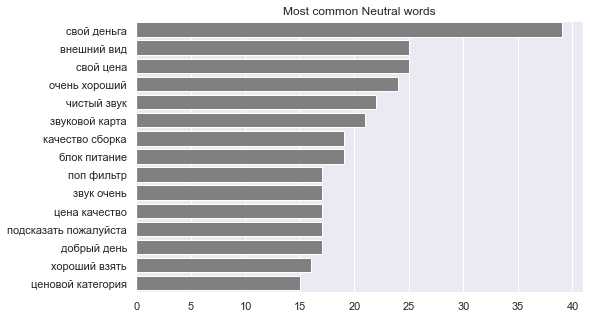

In [500]:
most_frequent(bigrams_neut, 'Neutral')

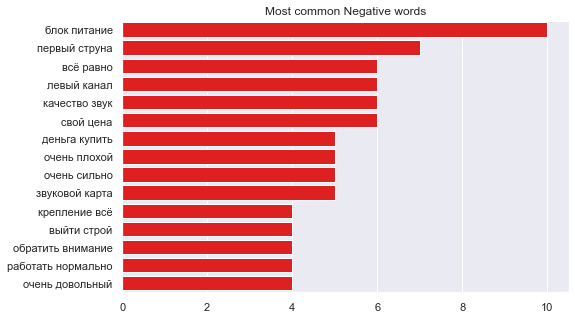

In [501]:
most_frequent(bigrams_neg, 'Negative')

Для униграмм графики наиболее частотных слов похожи даже между позитивными и негативными выборками отзывов. Но на биграммах различия уже видны. Так же и на триграммах.

In [251]:
trigrams_pos = generate_ngrams(df[df.sentiment=='Positive'].text_cleaned.values, 3)
trigrams_neut = generate_ngrams(df[df.sentiment=='Neutral'].text_cleaned.values, 3)
trigrams_neg = generate_ngrams(df[df.sentiment=='Negative'].text_cleaned.values, 3)

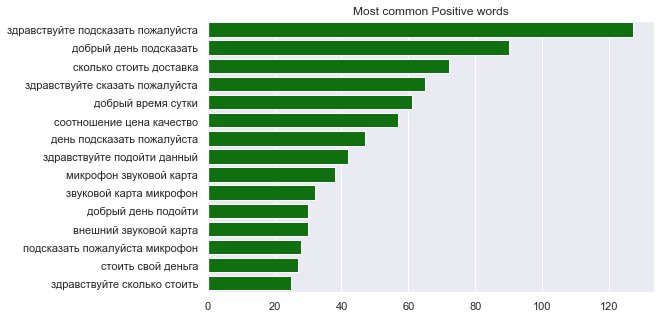

In [502]:
most_frequent(trigrams_pos, 'Positive')

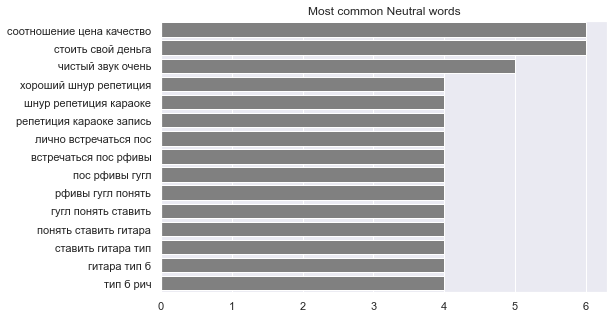

In [503]:
most_frequent(trigrams_neut, 'Neutral')

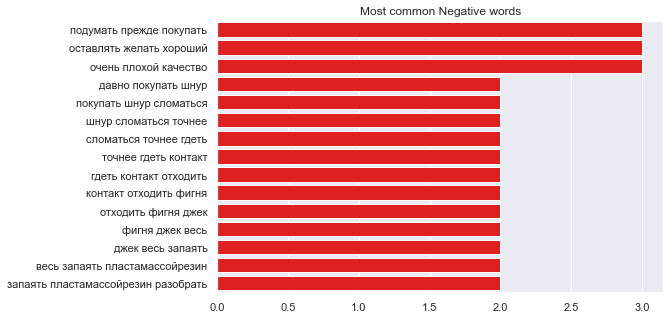

In [504]:
most_frequent(trigrams_neg, 'Negative')

### Handling imbalanced data

#### Getting extra data
Данные сильно не сбалансированны, и первые модели показывали высокую accuracy только за счет того, что преимущественно предсказывали оценки самого представленного класса. Есть возможность обогатить датасет данными несколькими способами:
- взять отзывы с нейтральными и негативными оценками с другого сайта
- взять отзывы с нейтральными и негативными оценками из датасета Kaggle
- создать искусственные сущности малопредставленных классов путем перевода отзыва на иностранный язык и обратного перевода на русский.

Все эти манипуляции с данными вынесены в отдельный ноутбук. здесь результаты соединения всех источников

In [637]:
df_full = pd.read_csv('Data/after_aug_full.csv')
df_full.head()

,text,rate
0,Это моя первая гитара. Консультант ответил на ...,4
1,Пожалуйста скажите кто-нибудь у кого он есть т...,3
2,клевая вещь. ка будет в МСК?,5
3,Пришлось снизить оценку -1 т.к. выснилось что ...,3
4,"Под ХР сразу не заработал, дрова надо везти с ...",4


In [638]:
df_full['sentiment'] = df_full.rate.apply(get_sentiment)

In [639]:
df_full.isnull().sum()

text         3
rate         0
sentiment    0
dtype: int64

In [640]:
df_full = df_full.dropna()

In [641]:
df_full.drop(df_full[df_full.sentiment==-1].index, inplace=True)

In [642]:
df_full['sentences'] = df_full['text'].apply(lambda x: review_to_sentences(x, tokenizer))
df_full['text_cleaned'] = df_full['sentences'].apply(lambda x: ' '.join(x))

In [643]:
df_full.to_csv('Data/after_aug_preprocessed.csv')

In [33]:
# df_full = pd.read_csv('Data/after_aug_preprocessed.csv')

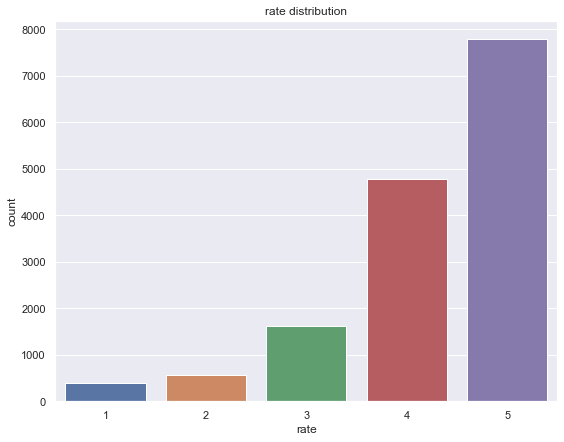

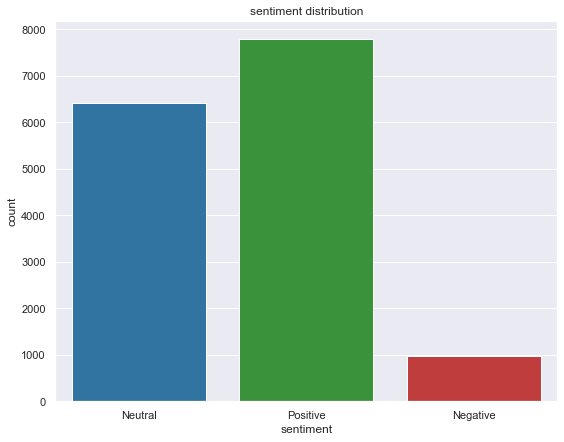

In [34]:
plot_count(df_full, ['rate', 'sentiment'])

Негативных отзывов по-прежнему значительно меньше, но в целом картина теперь более сбалансированная.

### Review embeddings

Эмбеддинги отзывов будем получать с помощью модели universal-sentence-encoder от tensorflow

Примечание: здесь в отличие от этапа EDA данные не лемматизируются, стоп-слова не удалены

In [151]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'

In [ ]:
model = hub.load(module_url)

In [337]:
def embed_text(input):
    return model(input)

In [338]:
# def get_avg_embed(sentences):
#     vectors = [embed_text(sent) for sent in sentences]
#     features = [np.array(vec)[0] for vec in vectors]
#     return sum(features)/len(features)

In [769]:
review_embeddings = [embed_text(sents) for sents in tqdm(df_full.sentences)]

100%|████████████████████████████████████████████████████████████████████████████| 15164/15164 [22:59<00:00, 10.99it/s]


In [772]:
features = [np.array(vec)[0] for vec in review_embeddings]

In [773]:
features[0]

array([ 2.50889435e-02,  1.45921940e-02, -3.24366707e-03,  5.39506972e-02,
        2.80524138e-03,  4.17258330e-02, -3.28141563e-02,  6.78619742e-02,
        1.92527473e-02,  1.71219301e-03,  2.47563794e-02, -2.76583945e-03,
       -5.02115786e-02, -4.15134691e-02, -9.79871862e-03, -8.16176459e-02,
        5.67616262e-02, -1.02089280e-02,  2.08990015e-02,  7.61493966e-02,
       -1.44009190e-02, -1.88124832e-02,  2.28703637e-02,  7.62632787e-02,
        4.45895717e-02, -5.48449717e-02,  3.58972736e-02,  5.31252995e-02,
        4.40389663e-02,  4.68753427e-02,  1.56867653e-02,  1.99432503e-02,
       -2.14840975e-02, -4.79593612e-02, -1.54269496e-02, -3.33655812e-02,
        6.61619455e-02,  5.65089360e-02,  3.11498605e-02, -1.02784097e-01,
        7.28475451e-02,  4.40087775e-03,  2.41239741e-03,  2.97181448e-03,
       -1.82451028e-02, -2.52154414e-02, -6.31105527e-02, -9.20046400e-03,
       -1.21336104e-03, -3.99171002e-02,  4.30778712e-02,  7.58779496e-02,
        6.57735392e-02,  

In [774]:
np_vec = np.array(features)
np_vec.shape

(15164, 512)

In [775]:
np.save('vectors_aug_1412', np_vec)

In [35]:
# features = np.load('vectors_aug_1412.npy')

In [781]:
df_full.sample(10)

,text,rate,sentiment,sentences,text_cleaned
14871,"Я виноват, что не сверил его размеры перед пок...",4,Neutral,[я виноватый что не сверить он размер перед по...,я виноватый что не сверить он размер перед пок...
7972,"Для своей цены вполне неплохая модель, отлично...",4,Neutral,[для свой цена вполне неплохой модель отлично ...,для свой цена вполне неплохой модель отлично п...
9231,"Спасибо за доставку в Волгодонск,дошла быстро,...",5,Positive,[спасибо за доставка в волгодонск дойти быстро...,спасибо за доставка в волгодонск дойти быстро ...
7792,"Неплохая гитара для начинающего басиста,как не...",5,Positive,[неплохой гитара для начинающий басистый как н...,неплохой гитара для начинающий басистый как не...
8382,"Несмотря на то, что гитара пришла упакованной,...",2,Negative,[несмотря на то что гитара прийти упаковать у ...,несмотря на то что гитара прийти упаковать у о...
12259,У меня есть 3 штуки для подключения кабелей XL...,2,Negative,[у я есть штука для подключение кабель к разъё...,у я есть штука для подключение кабель к разъём...
13238,"Я никогда не мог получить желаемый звук, испол...",4,Neutral,[я никогда не мочь получить желаемый звук испо...,я никогда не мочь получить желаемый звук испол...
6793,Здравствуйте. Посоветуйте струны серии ERNIE...,5,Positive,"[здравствуйте, посоветовать струна серия под с...",здравствуйте посоветовать струна серия под ста...
8301,Поддержу предыдущего оратора.\nЗа месяц эмоции...,5,Positive,"[поддержать предыдущий оратор, за месяц эмоция...",поддержать предыдущий оратор за месяц эмоция о...
13972,"Я никогда раньше не имел педали фузза, но проб...",4,Neutral,[я никогда ранний не иметь педаль фузз но проб...,я никогда ранний не иметь педаль фузз но пробо...


In [366]:
def cos_similarity(a, b):
    cos_sim = 1 - np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [782]:
# косинусное расстояние между векторами позитивного и негативного отзывов 
cos_similarity(vectors[9231],  vectors[13238])

0.8482875972986221

In [785]:
# косинусное расстояние между веторами двух позитивных отзывов - эти вектора находятся ближе друг к другу
cos_similarity(vectors[9231],  vectors[7792])

0.7885563671588898

### split data on train and test

Отделяю 20% исходного датасета для тестов уже после обучения модели, оставшиеся данные разбиваю на тренировочную и валидационную выборки

In [36]:
X, x_test, Y, y_test = train_test_split(features, df_full.sentiment, stratify=df_full.sentiment, test_size=0.2, random_state=146)

In [37]:
x_train, x_val, y_train, y_val = train_test_split(np.array(X), np.array(Y), stratify=Y, test_size=0.25, random_state=146)

In [38]:
print(x_train.shape)
print(x_val.shape)

(9098, 512)
(3033, 512)


### Baseline

In [11]:
lr = LogisticRegression(max_iter=5000)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_val)
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

    Negative       0.09      0.57      0.15        30
     Neutral       0.72      0.67      0.69      1370
    Positive       0.79      0.76      0.78      1633

    accuracy                           0.72      3033
   macro avg       0.53      0.67      0.54      3033
weighted avg       0.75      0.72      0.73      3033



Результат средний, скоры для меньшего класса оставляют желать лучшего 

### other classifiers

In [39]:
classifiers = {
    'lr_l1':LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=5000),
    'lr_l2':LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=5000),
    'tree':DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(), 
    'knc': KNeighborsClassifier(n_neighbors=7),
    'svc': SVC()
}

In [40]:
def train_and_predict(model, x_train, x_test, y_train, y_test):
    '''
    Обучение модели классификации и вывод результатов
    '''
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f'{model.__class__.__name__} result')
    print(classification_report(y_pred, y_test))
    print('----------------------------------')

In [16]:
for classifier in classifiers.values():
    train_and_predict(classifier, x_train, x_val, y_train, y_val)

LogisticRegression result
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         0
     Neutral       0.65      0.61      0.63      1354
    Positive       0.76      0.71      0.73      1679

    accuracy                           0.67      3033
   macro avg       0.47      0.44      0.46      3033
weighted avg       0.71      0.67      0.69      3033

----------------------------------
LogisticRegression result
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         0
     Neutral       0.73      0.66      0.69      1412
    Positive       0.79      0.76      0.77      1621

    accuracy                           0.71      3033
   macro avg       0.50      0.47      0.49      3033
weighted avg       0.76      0.71      0.73      3033

----------------------------------
DecisionTreeClassifier result
              precision    recall  f1-score   support

    Negative       0.13      0.

Как мы видим, классификаторы плохо справляются с малым классом негативных отзывов. Попробуем дополнительно преобразовать данные

### Undersampling, oversampling

In [41]:
Counter(Y)

Counter({'Positive': 6233, 'Neutral': 5125, 'Negative': 773})

Метод EditedNearestNeighbours позволяет уменьшить количество объектов классов таким образом, чтобы получить кластеры объектов, более четко отделенные друг от друга. Для нас это будет полезным, чтобы классификаторам было легче разделять данные по классам.

In [42]:
enn = EditedNearestNeighbours(sampling_strategy='majority', kind_sel='mode') 

In [43]:
X_resampled, Y_resampled = enn.fit_resample(X, Y)

In [44]:
Counter(Y_resampled)

Counter({'Negative': 773, 'Neutral': 5125, 'Positive': 4928})

In [45]:
smote = SMOTE(sampling_strategy='not majority')

In [46]:
X_resampled, Y_resampled = smote.fit_resample(X_resampled, Y_resampled)

In [47]:
Counter(Y_resampled)

Counter({'Negative': 5125, 'Neutral': 5125, 'Positive': 5125})

In [48]:
x_train, x_val, y_train, y_val = train_test_split(np.array(X_resampled), np.array(Y_resampled), test_size=0.25, random_state=146)

### Choosing a Classifier

In [49]:
def get_scores_from_report(clf):
    report_body = clf.split('\n\n')[1]
    items = report_body.split('\n')
    fscores_dict = {i.split()[0]: float(i.split()[-2]) for i in items}
    return fscores_dict

In [50]:
acc_dict = {}
fscores = {}

for name, classifier in classifiers.items():
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_val)
    print(f'{classifier.__class__.__name__} result')
    print(classification_report(y_pred, y_val))
    print('----------------------------------')
    acc_dict[name] = accuracy_score(y_pred, y_val)
    fscores[name] = get_scores_from_report(classification_report(y_pred, y_val))

LogisticRegression result
              precision    recall  f1-score   support

    Negative       0.71      0.63      0.67      1404
     Neutral       0.51      0.57      0.54      1148
    Positive       0.74      0.75      0.75      1292

    accuracy                           0.65      3844
   macro avg       0.65      0.65      0.65      3844
weighted avg       0.66      0.65      0.66      3844

----------------------------------
LogisticRegression result
              precision    recall  f1-score   support

    Negative       0.74      0.68      0.71      1373
     Neutral       0.57      0.61      0.59      1199
    Positive       0.76      0.78      0.77      1272

    accuracy                           0.69      3844
   macro avg       0.69      0.69      0.69      3844
weighted avg       0.70      0.69      0.69      3844

----------------------------------
DecisionTreeClassifier result
              precision    recall  f1-score   support

    Negative       0.82      0.

In [52]:
pd.DataFrame(fscores).T

,Negative,Neutral,Positive
lr_l1,0.67,0.54,0.75
lr_l2,0.71,0.59,0.77
tree,0.79,0.59,0.70
rfc,0.96,0.79,0.80
knc,0.69,0.38,0.78
svc,0.94,0.80,0.84


<AxesSubplot:title={'center':'F1-scores'}>

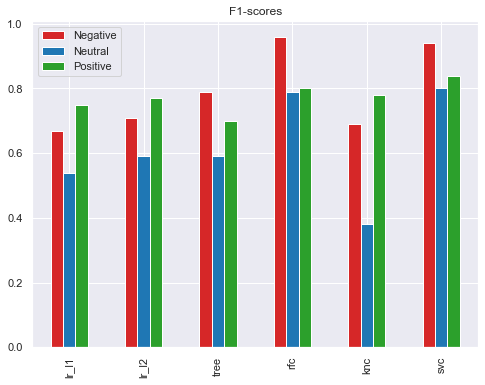

In [63]:
pd.DataFrame(fscores).T.plot(kind='bar', figsize=(8, 6), title='F1-scores', color=list(palette_sentiment.values()))

Text(0.5, 1.0, 'Accuracy scores')

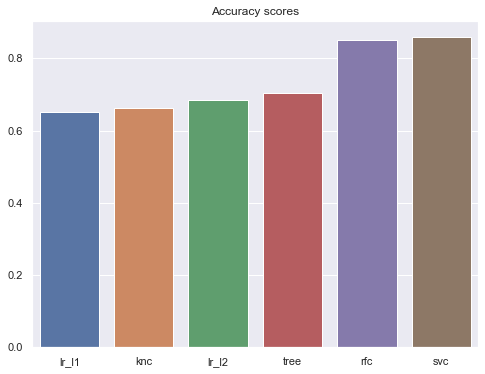

In [28]:
sorted_tuples = sorted(acc_dict.items(), key=lambda item: item[1])
sorted_dict = {k: v for k, v in sorted_tuples}
plt.figure(figsize=(8, 6))
sns.barplot(x=list(sorted_dict.keys()),y=[round(i, 3) for i in sorted_dict.values()]).set_title('Accuracy scores')

Наилучший результат и высокие f1-score для каждого класса показали RandomForestClassifier и SVC. 

### Hyperparameters tuning for the best classifiers

In [155]:
fscores_res = {}

In [59]:
param_grid = {'C':[1,10,100],'gamma':[1,0.1,0.001], 'kernel':['linear','rbf'], probability=True}

In [61]:
grid_svc = GridSearchCV(SVC(), param_grid, verbose=1)

In [ ]:
grid_svc.fit(x_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [7]:
# загружаю уже обученную модель

# with open('Models/svc_1512.sav', 'rb') as f:
#     grid_svc = pickle.load(f)

In [61]:
grid_svc.fit(x_train,y_train)

SVC(C=100, gamma=0.1, probability=True)

In [62]:
y_pred_svc = grid_svc.predict(x_val)

In [63]:
print(classification_report(y_val,y_pred_svc))

              precision    recall  f1-score   support

    Negative       0.92      0.94      0.93      1250
     Neutral       0.80      0.78      0.79      1288
    Positive       0.84      0.84      0.84      1306

    accuracy                           0.86      3844
   macro avg       0.86      0.86      0.86      3844
weighted avg       0.85      0.86      0.85      3844



Confusion matrix, without normalization


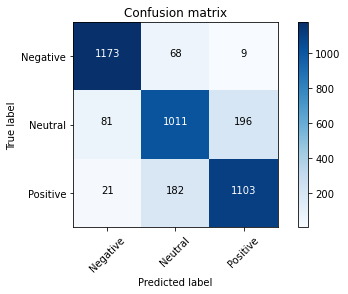

In [50]:
cm = confusion_matrix(y_val, y_pred_svc)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

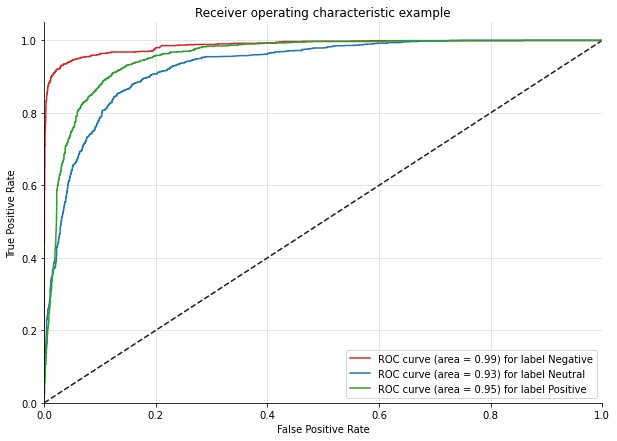

In [74]:
plot_multiclass_roc(grid_svc.predict_proba(x_val), y_val, 3)

In [51]:
np.save('y_pred_svc', np.array(y_pred_svc))

In [52]:
y_pred_svc_on_test = grid_svc.predict(x_test)

In [53]:
print(classification_report(y_test,y_pred_svc_on_test))

              precision    recall  f1-score   support

    Negative       0.34      0.33      0.34       194
     Neutral       0.69      0.78      0.73      1281
    Positive       0.85      0.76      0.80      1558

    accuracy                           0.74      3033
   macro avg       0.63      0.62      0.62      3033
weighted avg       0.75      0.74      0.74      3033



In [157]:
fscores_res['SVC'] = get_scores_from_report(classification_report(y_test,y_pred_svc_on_test))

Confusion matrix, without normalization


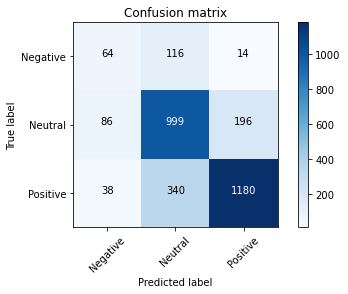

In [54]:
cm = confusion_matrix(y_test, y_pred_svc_on_test)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

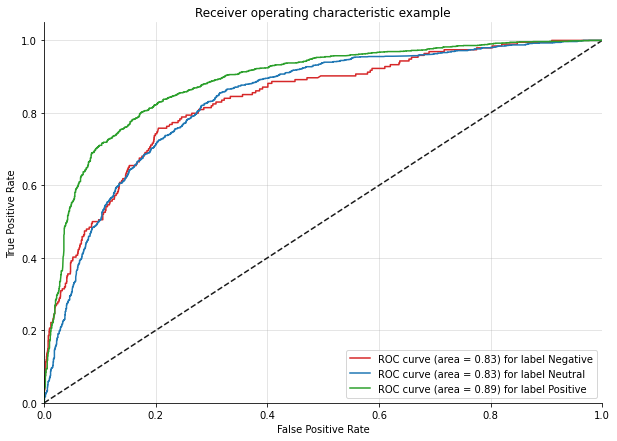

In [75]:
plot_multiclass_roc(grid_svc.predict_proba(x_test), y_test, 3)

In [173]:
fpr_svc = dict()
tpr_svc = dict()
roc_auc_svc = dict()

y_test_dummies_svc = pd.get_dummies(y_test, drop_first=False).values
for i in range(3):
    fpr_svc[i], tpr_svc[i], _ = roc_curve(y_test_dummies_svc[:, i], grid_svc_.predict_proba(x_test)[:, i])
    roc_auc_svc[i] = auc(fpr_svc[i], tpr_svc[i])

In [55]:
np.save('y_pred_svc_on_test', np.array(y_pred_svc_on_test))

In [167]:
filename = 'Models/svc_1512_fin.sav'
pickle.dump(grid_svc, open(filename, 'wb'))

### NN model

In [76]:
encoder = LabelEncoder()
encoder.fit(Y)

LabelEncoder()

In [77]:
dummy_y_train = utils.to_categorical(encoder.transform(y_train))
dummy_y_val = utils.to_categorical(encoder.transform(y_val))
dummy_y_test = utils.to_categorical(encoder.transform(y_test))

In [78]:
nn_model = Sequential()
nn_model.add(Dense(units=256, activation= 'relu', input_dim=x_train.shape[1]))
nn_model.add(Dense(units=128, activation= 'relu'))
nn_model.add(Dense(units=64, activation= 'relu'))
nn_model.add(Dense(units=32, activation= 'relu')) 
nn_model.add(Dense(units=3, activation= 'softmax'))

In [79]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 174,659
Trainable params: 174,659
Non-trainable params: 0
_________________________________________________________________


In [81]:
METRICS = [metrics.Precision(name='precision'),
  metrics.Recall(name='recall'),
  metrics.CategoricalAccuracy(name='acc'),
  metrics.AUC(name='auc'),
]

In [82]:
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [83]:
history = nn_model.fit(x_train, dummy_y_train, epochs=100, verbose=0, validation_data=(x_val, dummy_y_val))

In [42]:
history.history.keys()

dict_keys(['loss', 'precision', 'recall', 'acc', 'auc', 'val_loss', 'val_precision', 'val_recall', 'val_acc', 'val_auc'])

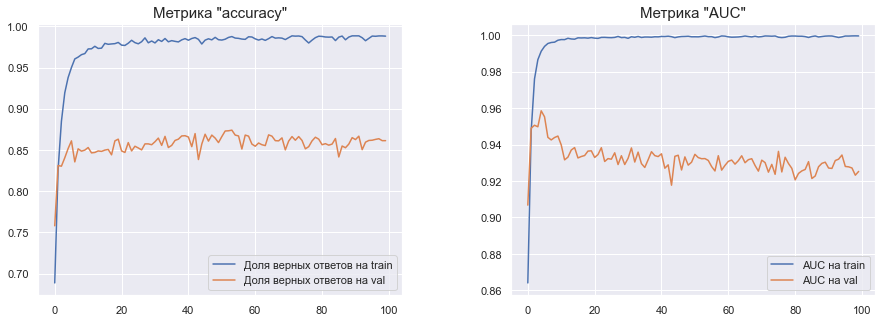

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

plt.subplots_adjust(wspace=0.3, hspace=0.5) # расстояние между графиками

ax[0].plot(history.history['acc'], 
         label='Доля верных ответов на train')
ax[0].plot(history.history['val_acc'], 
         label='Доля верных ответов на val')
ax[0].legend()
ax[0].set_title('Метрика "accuracy"', fontsize=15)


ax[1].plot(history.history['auc'], 
         label='AUC на train')
ax[1].plot(history.history['val_auc'], 
         label='AUC на val')
ax[1].legend()
ax[1].set_title('Метрика "AUC"', fontsize=15);

In [142]:
print("Evaluate on valid data")
results = nn_model.evaluate(x_val, dummy_y_val)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

Evaluate on valid data
121/121 [==============================] - 0s 2ms/step - loss: 0.8227 - precision: 0.8534 - recall: 0.8512 - acc: 0.8528 - auc: 0.9329
Test loss: 0.8227441310882568
Test accuracy: 0.8534168004989624


In [143]:
predictions = nn_model.predict(x_val)
y_pred_nn = np.argmax(predictions, axis=-1)
print(classification_report(y_pred_nn, encoder.transform(y_val)))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1366
           1       0.74      0.83      0.78      1153
           2       0.84      0.83      0.84      1325

    accuracy                           0.85      3844
   macro avg       0.85      0.85      0.85      3844
weighted avg       0.86      0.85      0.86      3844



In [56]:
fscores['nn_on_valid'] = get_scores_from_report(classification_report(y_pred_nn, encoder.transform(y_val)))

Confusion matrix, without normalization


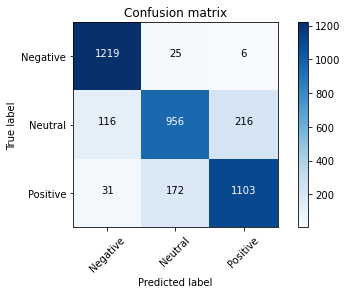

In [145]:

cm = confusion_matrix( encoder.transform(y_val), y_pred_nn)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

In [97]:
print("Evaluate on test data")
results = nn_model.evaluate(np.array(x_test), dummy_y_test)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

Evaluate on test data
95/95 [==============================] - 0s 2ms/step - loss: 2.4909 - precision: 0.7331 - recall: 0.7316 - acc: 0.7319 - auc: 0.8309
Test loss: 2.490919351577759
Test accuracy: 0.7330690622329712


In [98]:
predictions_on_test = nn_model.predict(np.array(x_test))
y_pred_nn_on_test = np.argmax(predictions_on_test, axis=-1)
print(classification_report(y_pred_nn_on_test, encoder.transform(y_test)))

              precision    recall  f1-score   support

           0       0.39      0.32      0.35       232
           1       0.76      0.68      0.72      1431
           2       0.75      0.86      0.80      1370

    accuracy                           0.73      3033
   macro avg       0.63      0.62      0.62      3033
weighted avg       0.73      0.73      0.73      3033



In [159]:
fscores_res['NN'] = get_scores_from_report(classification_report(y_pred_nn_on_test, encoder.transform(y_test)))

In [57]:
fscores['nn_on_test'] = get_scores_from_report(classification_report(y_pred_nn_on_test, encoder.transform(y_test)))

Confusion matrix, without normalization


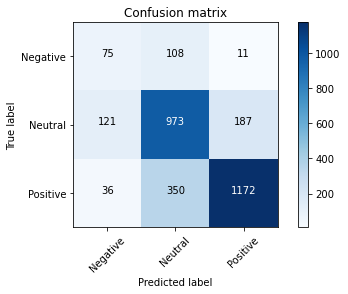

In [100]:
cm = confusion_matrix(encoder.transform(y_test), y_pred_nn_on_test)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

In [55]:
np.save('y_pred_nn', np.array(y_pred_nn))
np.save('y_pred_nn_on_test', np.array(y_pred_nn_on_test))

In [87]:
fpr_nn = dict()
tpr_nn = dict()
roc_auc_nn = dict()

In [101]:
for i in range(3):
    fpr_nn[i], tpr_nn[i], _ = roc_curve(dummy_y_test[:, i], predictions_on_test[:, i])
    roc_auc_nn[i] = auc(fpr_nn[i], tpr_nn[i])

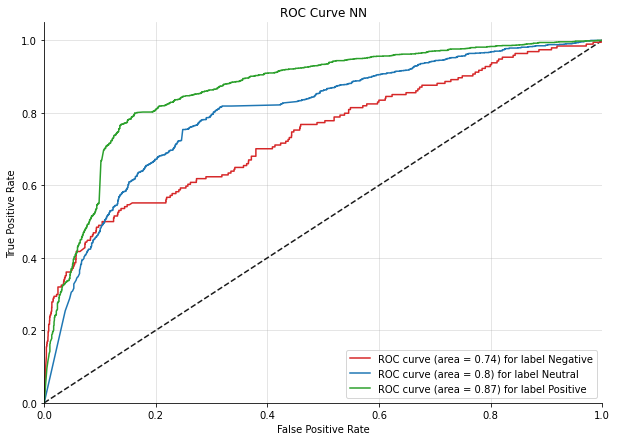

In [102]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve NN')
for i in range(3):
#     ax.plot(fpr_nn[i], tpr_nn[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc_nn[i], i))
    ax.plot(fpr_nn[i], tpr_nn[i], color=palette_sentiment[inversed_label_dict[i]],
                label=f'ROC curve (area = {round(roc_auc_nn[i], 2)}) for label {inversed_label_dict[i]}' )
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [580]:
nn_model.save('Models/keras_nn')

INFO:tensorflow:Assets written to: Models/keras_nn\assets


INFO:tensorflow:Assets written to: Models/keras_nn\assets


Результаты выглядят сопоставимо с SVC, но несколько хуже, особенно для класса негативных отзывов. С учетом того, что такая модель обучается дольше, чем классификатор sklearn, решение пользоваться ей выглядит нецелесообразным. 

### Bert

Эти модели используют свои алгоритмы токенизации. Возьму предобученную на русском корпусе модель Bert и дообучу на своих данных. В токенизатор подаю данные из исходного датасета, до under- и oversampling-а  

In [110]:
tokenizer_dp = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased", do_lower_case=True)


In [111]:
df_short = df_full[['text', 'sentiment']]

In [112]:
df_short.sentiment.unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

In [74]:
label_dict =  {'Negative':0, 'Neutral':1, 'Positive':2}

In [113]:
df_short['label'] = df_short.sentiment.replace(label_dict)

In [114]:
df_short  = df_short.drop('sentiment', axis=1)

In [115]:
df_short.head()

,text,label
0,Это моя первая гитара. Консультант ответил на ...,1
1,Пожалуйста скажите кто-нибудь у кого он есть т...,1
2,клевая вещь. ка будет в МСК?,2
3,Пришлось снизить оценку -1 т.к. выснилось что ...,1
4,"Под ХР сразу не заработал, дрова надо везти с ...",1


In [116]:
df_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15164 entries, 0 to 15163
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15164 non-null  object
 1   label   15164 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 237.1+ KB


In [117]:
# разбивка на тренировочный и тестовый датасеты
x_train_dp, x_val_dp, y_train_dp, y_val_dp = train_test_split(df_short.index.values, 
                                                  df_short.label.values, 
                                                  test_size=0.2, 
                                                  random_state=146, 
                                                  stratify=df_short.label.values)

df_short['data_type'] = ['not_set']*df_short.shape[0]

df_short.loc[x_train_dp, 'data_type'] = 'train'
df_short.loc[x_val_dp, 'data_type'] = 'val'

In [118]:
df_short.groupby(['label', 'data_type']).count()

text
label data_type      
0     train       773
      val         194
1     train      5125
      val        1281
2     train      6233
      val        1558

In [121]:
# токенизация текстов
encoded_data_train = tokenizer_dp.batch_encode_plus(
    list(df_short[df_short.data_type=='train'].text.values), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt'
)

In [122]:
encoded_data_train[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [123]:
encoded_data_val = tokenizer_dp.batch_encode_plus(
    list(df_short[df_short.data_type=='val'].text.values), 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=512, 
    return_tensors='pt'
)

In [124]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_short[df_short.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_short[df_short.data_type=='val'].label.values)

In [125]:
# тензоры для обучения Bert
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [126]:
from transformers import BertForSequenceClassification

In [105]:
model_dp = BertForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased", 
                                     num_labels=3, 
                                     output_attentions=False,
                                     output_hidden_states=False)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

In [127]:
batch_size = 5

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [128]:
optimizer = AdamW(model_dp.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [129]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [130]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [131]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        acc_percent = round(len(y_preds[y_preds==label]) / len(y_true) *100, 2)
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)} ({acc_percent}%)\n')

In [132]:
seed_val = 146
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [133]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dp.to(device)
print(device)

cpu


In [134]:
def evaluate(dataloader_val):

    model_dp.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model_dp(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model_dp.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_dp.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model_dp(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_dp.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model_dp.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Обучение выполнялось в среде google colab, так быстрее. Загружаю подготовленную там модель.

In [106]:
model_dp.load_state_dict(torch.load('Models/finetuned_BERT_epoch_5.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [135]:
_, predictions_dp, true_vals_dp = evaluate(dataloader_validation)

In [136]:
accuracy_per_class(predictions_dp, true_vals_dp)

Class: Negative
Accuracy: 113/194 (58.25%)

Class: Neutral
Accuracy: 1069/1281 (83.45%)

Class: Positive
Accuracy: 1347/1558 (86.46%)



In [138]:
y_pred_dp = np.argmax(predictions_dp, axis=1)

In [164]:
clf_dp = classification_report(y_pred_dp, true_vals_dp)

In [165]:
print(clf_dp)

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       194
           1       0.83      0.79      0.81      1350
           2       0.86      0.90      0.88      1489

    accuracy                           0.83      3033
   macro avg       0.76      0.76      0.76      3033
weighted avg       0.83      0.83      0.83      3033



In [167]:
fscores_res['RuBert'] = get_scores_from_report(clf_dp)

In [108]:
np.save('true_vals', np.array(true_vals_dp))
np.save('y_pred_dp', np.array(y_pred_dp))
np.save('pred_proba_dp', np.array(predictions_dp))

Confusion matrix, without normalization


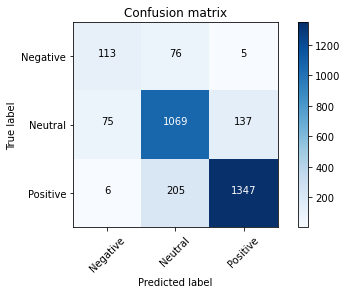

In [111]:
cm = confusion_matrix(true_vals_dp, y_pred_dp)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

Bert более точно определяет негативные отзывы по сравнению с предыдущими моделями. Заметно меньше ошибок, связанных с путаницей позитивных и негативных (тонально не близких) отзывов.  

In [141]:
fpr_dp = dict()
tpr_dp = dict()
roc_auc_dp = dict()

In [142]:
true_vals_dummies_dp = pd.get_dummies(true_vals_dp, drop_first=False).values
for i in range(3):
    fpr_dp[i], tpr_dp[i], _ = roc_curve(true_vals_dummies_dp[:, i], predictions_dp[:, i])
    roc_auc_dp[i] = auc(fpr_dp[i], tpr_dp[i])

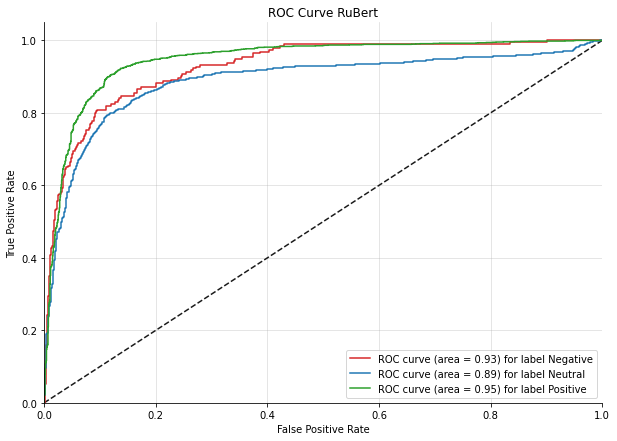

In [143]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve RuBert')
for i in range(3):
#     ax.plot(fpr_dp[i], tpr_dp[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc_dp[i], i))
    ax.plot(fpr_dp[i], tpr_dp[i], color=palette_sentiment[inversed_label_dict[i]],
                label=f'ROC curve (area = {round(roc_auc_dp[i], 2)}) for label {inversed_label_dict[i]}' )
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [194]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [195]:
t1 =predictions_dp[0]
t1

array([-4.6141696,  3.1914096,  1.0273441], dtype=float32)

In [210]:
# предсказания в формате вероятностей принадлжености к классу
pred_softmax = np.array([softmax(prediction) for prediction in predictions_dp])

In [202]:
max([sum(p) for p in pred_softmax])

1.0000001281150617

In [203]:
fpr_dp_2 = dict()
tpr_dp_2 = dict()
roc_auc_dp_2 = dict()

In [211]:
pred_softmax[:,  1]

array([8.9664817e-01, 6.2247243e-04, 9.9941635e-01, ..., 9.9921298e-01,
       9.9947709e-01, 9.9498582e-01], dtype=float32)

In [212]:
for i in range(3):
    fpr_dp_2[i], tpr_dp_2[i], _ = roc_curve(true_vals_dummies_dp[:, i], pred_softmax[:, i])
    roc_auc_dp_2[i] = auc(fpr_dp_2[i], tpr_dp_2[i])

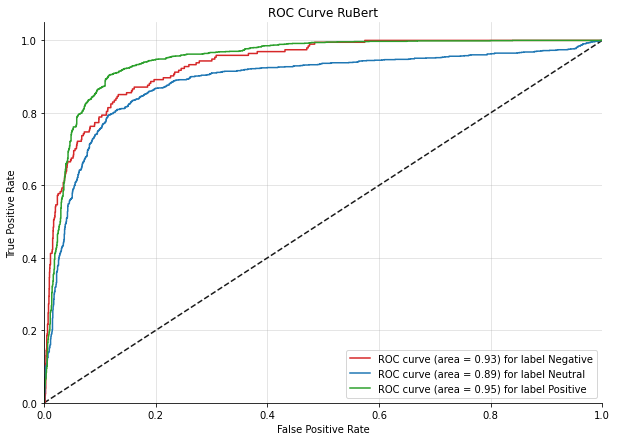

In [213]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve RuBert')
for i in range(3):
#     ax.plot(fpr_dp[i], tpr_dp[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc_dp[i], i))
    ax.plot(fpr_dp_2[i], tpr_dp_2[i], color=palette_sentiment[inversed_label_dict[i]],
                label=f'ROC curve (area = {round(roc_auc_dp_2[i], 2)}) for label {inversed_label_dict[i]}' )
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

Результаты те же, что и без softmax-а на выходных данных.

### Final scores

In [175]:
res_dict = {
    'SVC':roc_auc_svc,
    'NN': roc_auc_nn, 
    'RuBert': roc_auc_dp
} 

In [176]:
df_roc_auc = pd.DataFrame(res_dict).T

In [192]:
df_roc_auc = df_roc_auc.rename(inversed_label_dict,  axis='columns')
df_roc_auc = df_roc_auc.round(2)
df_roc_auc

,Negative,Neutral,Positive
SVC,0.83,0.83,0.89
NN,0.74,0.80,0.87
RuBert,0.93,0.89,0.95


In [183]:
fscores_res

{'SVC': {'Negative': 0.34, 'Neutral': 0.73, 'Positive': 0.8},
 'NN': {'0': 0.35, '1': 0.72, '2': 0.8},
 'RuBert': {'0': 0.58, '1': 0.81, '2': 0.88}}

In [185]:
for key in fscores_res['NN'].keys():
    fscores_res['NN'][inversed_label_dict[int(key)]] = fscores_res['NN'].pop(key)

for key in fscores_res['RuBert'].keys():
    fscores_res['RuBert'][inversed_label_dict[int(key)]] = fscores_res['RuBert'].pop(key)


In [189]:
fscores_res

{'SVC': {'Negative': 0.34, 'Neutral': 0.73, 'Positive': 0.8},
 'NN': {'Negative': 0.35, 'Neutral': 0.72, 'Positive': 0.8},
 'RuBert': {'Negative': 0.58, 'Neutral': 0.81, 'Positive': 0.88}}

In [190]:
df_fscore = pd.DataFrame(fscores_res).T
df_fscore

,Negative,Neutral,Positive
SVC,0.34,0.73,0.80
NN,0.35,0.72,0.80
RuBert,0.58,0.81,0.88


In [193]:
df_results = pd.concat([df_roc_auc, df_fscore], axis=1, keys=['ROC AUC', 'F1 score'])
df_results

ROC AUC                  F1 score                 
       Negative Neutral Positive Negative Neutral Positive
SVC        0.83    0.83     0.89     0.34    0.73     0.80
NN         0.74    0.80     0.87     0.35    0.72     0.80
RuBert     0.93    0.89     0.95     0.58    0.81     0.88

В таблице представлены метрики ROC AUC и f1 score для каждого класса, полученные классификаторами на тестовой выборке. 

Bert справилася с классификацией лучше прочих классификаторов. Его минусы - долгое обучение, так же он долго формирует предсказания 

Классификатор SVC в связке с эмбеддингами от universal sentence encoder показывают приемлемый результат, обучается достаточно быстро

Эксперимент с нейросетью был скорее познавательным, чем необходимым, особенно с учетом того, что существуют специализированные  модели типа Bert, доказавшие свою эффективность. Обучается она дольше SVC, но результаты ниже. 